## Assignment 02
For this assignment, we will analyze real estate evaluation dataset from
*Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.*

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
seed=0 # use this random seed throughout your code

### Question 1: Load and visualize the data (15 Points) 
Read the data file `Real_estate_valuation_dataset.csv`:


In [92]:
data = pd.read_csv('Real_estate_valuation_dataset.csv')
data.head()

,transaction_date,house_age,distance_to_the_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,house_price_of_unit_area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


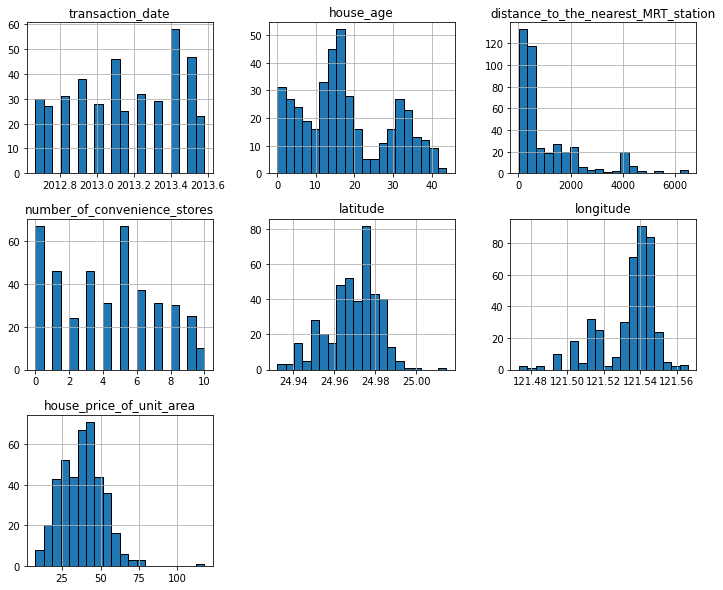

In [93]:
# Use hist to plot the distribution of the data
# Select a proper bin size 
data.hist(figsize=(12, 10), bins=20, edgecolor="black")
plt.show()

In [94]:
# Compute the standard correlation coefficient between every pair of attributes:
corr_matrix = data.corr()
corr_matrix["house_price_of_unit_area"].sort_values(ascending=False)[1:]

number_of_convenience_stores           0.571005
latitude                               0.546307
longitude                              0.523287
transaction_date                       0.087491
house_age                             -0.210567
distance_to_the_nearest_MRT_station   -0.673613
Name: house_price_of_unit_area, dtype: float64

**Written Answer**: Explain how much each attribute correlates with house_price_of_unit_area?

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the "house_price_of_unit_area" tends to go up when "number_of_convenience_stores" goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see, for example, a negative correlation between "distance_to_the_nearest_MRT_station" and "house_price_of_unit_area" (i.e., prices have a tendency to go down when they are closer to the MRT station). Finally, coefficients close to 0 mean that there is no/little linear correlation e.g., transaction_date.

### Question 2: Simple Linear Regression (30 points)
Let's first examine one feature `distance_to_the_nearest_MRT_station` to see if it can be used to predict `house_price_of_unit_area`:

In [95]:
# Read the corresponding column
x = data.distance_to_the_nearest_MRT_station.values
y = data.house_price_of_unit_area.values

# Make x into a design matrix
x = np.c_[np.ones(x.size), x]

# Split the data into training and test set with 20% test size and random_state=seed
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=seed)

Let's first use LinearRegression from Sklearn:

In [96]:
# Because the values of features vary in magnitude, we often
# standardize features by removing the mean and scaling to unit
# variance using sklearn.preprocessing.StandardScaler

# Define the model
lin_reg = LinearRegression()
model = make_pipeline(StandardScaler(), lin_reg)

# Fit the model using the training set
model.fit(xtrain, ytrain)

# Obtain intercept and coefficient
intercept = lin_reg.intercept_
coefficient = lin_reg.coef_
print("Intercept is:", intercept.round(3))
print("Coefficients are:", coefficient.round(3))

# Obtain coefficient of determination (R-squared) on the training data
r2_train = r2_score(ytrain, model.predict(xtrain))
# r2_train = model.score(xtrain, ytrain)
print("Coefficient of determination on the training set: %.3f" % r2_train)

# Make predictions using the testing set
ypred = model.predict(xtest)

# Evaluate performance on the test data
r2_test = r2_score(ytest, ypred)
r2_test = model.score(xtest, ytest)
print("Coefficient of determination on the test set: %.3f" % r2_test)

Intercept is: 37.976
Coefficients are: [ 0.    -9.073]
Coefficient of determination on the training set: 0.439
Coefficient of determination on the test set: 0.516


**Written Answer**: Based on the R-squared of training and test set, will it be better to use regularized regression?

R-squared determines how much of total variation in Y is explained by variation in X. An R-squared of 0 means the model does not explain the variablity in Y, and 1 meaning full variablity in the target variablity. Here, the model has poor performance on both training and test sets, and it does better on instances that it never saw during training (test set). Choosing a wrong model (either too simple or too complex) can rendomly lead to this scenario. Regularization is about calibrating models in order to minimize the adjusted loss function and prevent overfitting or underfitting. Since we are seeing an underfitting model, it is worth trying regularization. However, as you will see in the scatter plot below, the the dataset seems to follow an exponentially decaying (i.e., nonlinear) behaviour and we can not expect a great fit with linear regression no matter regularized or otherwise.

### Extras:
To better evaluate a model we would do cross-validation that is to randomly split the training set into N distinct subsets (i.e. folds) and train and evaluate the model N times, picking a different fold (validation set) for evaluation every time and training on the other N-1 folds:

In [97]:
from sklearn.model_selection import cross_val_score
N =5 
scores = cross_val_score(model, xtrain, ytrain, scoring="r2", cv=N)
print("Number of folds:", N)
print("Scores:", scores.round(3))
print("Mean:", scores.mean().round(3))
print("Standard deviation:", scores.std().round(3))

Number of folds: 5
Scores: [0.362 0.552 0.492 0.352 0.414]
Mean: 0.434
Standard deviation: 0.077


We can see that cross-validation also shows a similar score of about 0.43 with a low standard deviation, which is a good thing. At least you know now that the score you got in the previous step is consistent across different folds of the training set. Now, let's try ElasticNet regularization to see if we can make the model any better. We remember from the lecture notes that we need to give two parameters (i.e, alpha and l1-ratio) to ElasticNet. The first one determines how strong regularize bias and the latter variance. But, how to choose values? We can use the cross-validated version of ElasticNet that is `ElasticNetCV`. It goes through N folds and finds the best parameters and train the model based on them.

In [98]:
from sklearn.linear_model import ElasticNetCV

eps = 5e-3 # The smaller eps, the longer the path  
lin_reg_en = ElasticNetCV(eps = eps, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=3, random_state=seed)

model2 = make_pipeline(StandardScaler(), lin_reg_en)

# Fit it
model2.fit(xtrain, ytrain)

# Obtain intercept and coefficient
intercept = lin_reg_en.intercept_
coefficient = lin_reg_en.coef_
print("Intercept is:", intercept.round(3))
print("Coefficients are:", coefficient.round(3))

# Obtain best alpha and l1_ratio that ElasticNetCV found
print('Best fit: alpha=%.3f, l1_ratio=%.3f' % (lin_reg_en.alpha_, lin_reg_en.l1_ratio_))

# Obtain coefficient of determination (R-squared) on the training data
r2_train = r2_score(ytrain, model2.predict(xtrain))
# r2_train = model2.score(xtrain, ytrain)
print("Coefficient of determination on the training set: %.3f" % r2_train)

# Make predictions using the testing set
ypred2 = model2.predict(xtest)

# Evaluate performance on the test data
r2_test = r2_score(ytest, ypred2)
# r2_test = model2.score(xtest, ytest)
print("Coefficient of determination on the test set: %.3f" % r2_test)

Intercept is: 37.976
Coefficients are: [ 0.    -8.855]
Best fit: alpha=0.065, l1_ratio=0.700
Coefficient of determination on the training set: 0.439
Coefficient of determination on the test set: 0.515


As expected, cross-validated ElasticNet regularization did not do much and we got almost the same score. However, one should notice that it did decrease the absolute value of the coefficient. We wish to have smaller coefficients and have them set to zero if they are too small.

Alternatively, you can use the alpha and l1_ratio calculated in the previous step as the arguments to pass on for training a simple ElasticNet model and the result will be the same:

In [99]:
from sklearn.linear_model import ElasticNet
lin_reg_en2 = ElasticNet(alpha=lin_reg_en.alpha_, l1_ratio=lin_reg_en.l1_ratio_, random_state=seed)
model3 = make_pipeline(StandardScaler(), lin_reg_en2)

# Fit it
model3.fit(xtrain, ytrain)

# Obtain intercept and coefficient
intercept = lin_reg_en2.intercept_
coefficient = lin_reg_en2.coef_
print("Intercept is:", intercept.round(3))
print("Coefficients are:", coefficient.round(3))

# Obtain coefficient of determination (R-squared) on the training data
r2_train = r2_score(ytrain, model3.predict(xtrain))
# r2_train = model3.score(xtrain, ytrain)
print("Coefficient of determination on the training set: %.3f" % r2_train)

# Make predictions using the testing set
ypred2 = model3.predict(xtest)

# Evaluate performance on the test data
r2_test = r2_score(ytest, ypred2)
# r2_test = model3.score(xtest, ytest)
print("Coefficient of determination on the test set: %.3f" % r2_test)

Intercept is: 37.976
Coefficients are: [ 0.    -8.855]
Coefficient of determination on the training set: 0.439
Coefficient of determination on the test set: 0.515


### End of Extras.

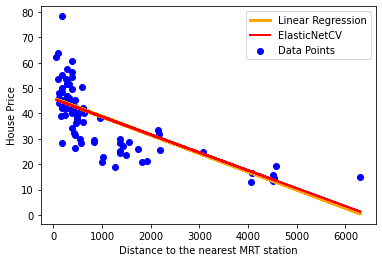

In [100]:
# Plot test data and predicted data
plt.scatter(xtest[:,1:], ytest, color='blue', label='Data Points')
plt.plot(xtest[:,1:], ypred, color="orange", linewidth=3, label='Linear Regression')
plt.plot(xtest[:,1:], ypred2, color="red", linewidth=2, label='ElasticNetCV')
plt.xlabel('Distance to the nearest MRT station')
plt.ylabel('House Price')
plt.legend()
plt.show()

In [101]:
# Define a function to plot learning curves based on R-squared metric:

def plot_learning_curves_R2(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
    train_errors, val_errors = [], []
    for m in range(3, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(r2_score(y_train[:m], y_train_predict))
        val_errors.append(r2_score(y_val, y_val_predict))
    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(val_errors, "b-", linewidth=3, label="val")    
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel('$R^2$', fontsize=14)

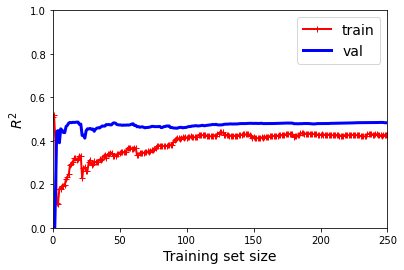

In [102]:
plot_learning_curves_R2(model, xtrain, ytrain) # This is the correct way of doing it
# however, for this assignment doing it this way:
# plot_learning_curves_R2(model, x, y) # will be also okay. 
plt.axis([0, 250, 0, 1])
plt.show()

**Written Answer**: Explain how do you interpret the learning curves you just plotted?

As new instances are added to the training set, the model fails to fit the training data and the curves saturate to a small R2 score, because the data is noisy and it is not linear at all and therefore this model is underfitting. The error on the training data goes up until it reaches a plateau (around training set size of 110), at which point adding new instances to the training set doesn’t make the average error much better or worse. If a right model is chosen for a given dataset, you would normally expect to see better performance on the training set (red curve) than the validation set, but here is the other way round (look at the gap between the curves). If you used a much larger training set, the two curves would not get closer. Therefore, in this scenario, rather than going after collecting more datapoints for training, better to go after finding a proper model.  

### Question 3: Multivariate Linear Regression (30 Points)

We just used only one feature to predict house price. But sometimes using more features can better predict the target variable. 

Here, let's examine another two features: latitude and longitude. These two variables together give information about the location, which should be related to house price:

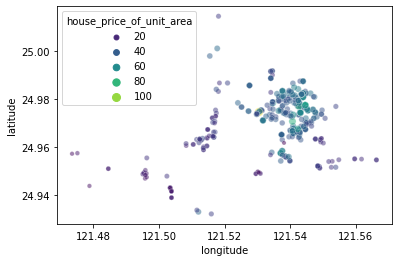

In [103]:
# Let's visualize it using sns scatterplot
sns.scatterplot(data=data, x="longitude", y="latitude",
                size="house_price_of_unit_area", hue="house_price_of_unit_area",
                palette="viridis", alpha=0.5)
plt.show()

In [112]:
# Read the corresponding column
y = data.house_price_of_unit_area.values
longitude = data.longitude.values 
latitude = data.latitude.values

# Make x into a design matrix
N = len(latitude)
x = np.c_[np.ones(N), longitude, latitude]
# x = data[['longitude', 'latitude']]

# Split the data into training and test set with 20% test size and random_state=seed
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=seed)

Let's use linear regression again:

In [113]:
# Define the model
lin_reg = LinearRegression()
model = make_pipeline(StandardScaler(), lin_reg)

# Fit the model using the training set
# model.fit(xtrain, ytrain.ravel())
model.fit(xtrain, ytrain)

# Obtain intercept and coefficient
intercept = lin_reg.intercept_
coefficient = lin_reg.coef_
print("Intercept is:", intercept.round(4))
print("Coefficient are:", coefficient.round(4))

# Obtain coefficient of determination on the training data
# r2_train = r2_score(ytrain, model.predict(xtrain))
r2_train = model.score(xtrain, ytrain)
print("Coefficient of determination on the training set: %.4f" % r2_train)

# Make predictions using the testing set
ypred = model.predict(xtest)

# Evaluate performance on the test data
r2_test = r2_score(ytest, ypred)
r2_test = model.score(xtest, ytest)
print("Coefficient of determination on the test set: %.4f" % r2_test)

Intercept is: 37.9764
Coefficient are: [0.     4.9152 5.3401]
Coefficient of determination on the training set: 0.3958
Coefficient of determination on the test set: 0.4450


Use the "plot_learning_curves" function to plot the learning curves of the model:

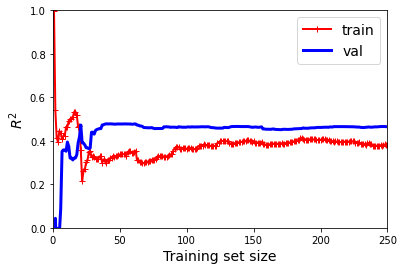

In [114]:
plot_learning_curves_R2(model, xtrain, ytrain) # This is the correct way of doing it
# however, for this assignment doing it this way:
# plot_learning_curves_R2(model, x, y) # will be also okay. 
plt.axis([0, 250, 0, 1])
plt.show()

**Written Answer**: Compare this learning curve against the previous one. What insights you can derive by this comparison?

The curve reaches a plateau around training set size of 130 which is bigger than that of the previous figure. Performance scores on both curves saturate to lower scores.

Let's use stochastic gradient descent with initial learning rate of 0.01:

In [115]:
# Define the model
sgd_reg = SGDRegressor(max_iter=100000, tol=1e-3, eta0=0.01, random_state=seed)
model = make_pipeline(StandardScaler(), sgd_reg)

# Fit the model using the training set
model.fit(xtrain,ytrain)

# Obtain intercept and coefficient
intercept = sgd_reg.intercept_
coefficient = sgd_reg.coef_
print("Intercept is: %.4f" % intercept)
print("Coefficient are:", coefficient.round(4))

# Obtain coefficient of determination on the training data
# r2_train = r2_score(ytrain, model.predict(xtrain))
r2_train = model.score(xtrain, ytrain)
print("Coefficient of determination on the training set: %.4f" % r2_train)

# Make predictions using the testing set
ypred = model.predict(xtest)

# Evaluate performance on the test data
r2_test = r2_score(ytest, ypred)
r2_test = model.score(xtest, ytest)
print("Coefficient of determination on the test set: %.4f" % r2_test)

Intercept is: 37.9843
Coefficient are: [0.     4.8968 5.3264]
Coefficient of determination on the training set: 0.3958
Coefficient of determination on the test set: 0.4448


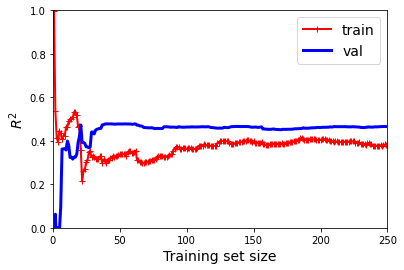

In [116]:
plot_learning_curves_R2(model, xtrain, ytrain) # This is the correct way of doing it
# however, for this assignment doing it this way:
# plot_learning_curves_R2(model, x, y) # will be also okay. 
plt.axis([0, 250, 0, 1])
plt.show()

**Written Answer:** Compare the scores and learning curves of the SGD regression versus the linear regression. Are the learning curves similar or different and why? Also compare and explain why their values for Intercept and Coefficient are a little bit different?
(Hint: Check and compare default arguments and cost functions for both methods)

The curves are somehow identical however SGD yields slightly smaller scores and that's because it does not converge exactly to the ideal minimum of the cost function, but somewhere very close to it. We see smaller values for the coefficients and that's because unless set to `False` SGDRegressor applies some L2 regularization by default.

### Question 4: Feature Selection (25 Points)
Now, let's use all available features to predict house price:

In [131]:
features = data.drop('house_price_of_unit_area', axis='columns')
x = features.values
N = len(features)
x = np.c_[np.ones(N), x]

# Split the data into training and test set with 20% test size and random_state=0
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=seed)

Let's use Ridge regression with alpha = 0.01:

In [132]:
# Define the model
ridge_reg = Ridge(alpha=0.01, solver="cholesky", random_state=seed)
model = make_pipeline(StandardScaler(), ridge_reg)

# Fit the model using the training set
model.fit(xtrain,ytrain)

# Obtain intercept and coefficient
intercept = ridge_reg.intercept_
coefficient = ridge_reg.coef_
print("Intercept is:", intercept.round(3))
print("Coefficient are:", coefficient.round(3))

# Obtain coefficient of determination on the training data
# r2_train = r2_score(ytrain, model.predict(xtrain))
r2_train = model.score(xtrain, ytrain)
print("Coefficient of determination on the training set: %.3f" % r2_train)

# Make predictions using the testing set
ypred = model.predict(xtest)

# Evaluate performance on the test data
r2_test = r2_score(ytest, ypred)
r2_test = model.score(xtest, ytest)
print("Coefficient of determination on the test set: %.3f" % r2_test)

Intercept is: 37.976
Coefficient are: [ 0.     1.411 -2.969 -5.607  3.171  2.863 -0.103]
Coefficient of determination on the training set: 0.565
Coefficient of determination on the test set: 0.657


Text(0.5, 0, 'Coefficient')

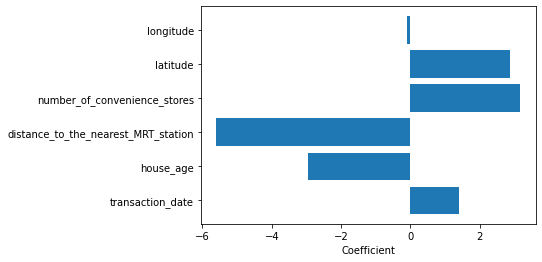

In [129]:
# Use plot.barh to plot the value of coefficient

# Select coefficient expect for the first bias one
coefficient_feature = coefficient[1:]

# Get the names of features
features_name = list(features.columns)

# Plot
plt.barh(features_name,coefficient_feature)
plt.xlabel('Coefficient')

**Written Answer:** How do you interpret the result? How can it help you to select features to predict price? How does this result compare against the insights that you derived form the correlation matrix in Question 1?

The bar chart ranks _distance_to_the_nearest_MRT_station_ and _house_age_ as the top 2 influential features which is a consistent conclusion as with the correlation matrix. Those features with positive correlations led to positive coefficients and those with negative correlations led to negative coefficients. Remember, that `corr_matrix` captures only linear correlation and here we already saw that a linear model does not seem to be the best option for this dataset. And that's why there is some discrepancy between the correlation matrix and the bar chart.

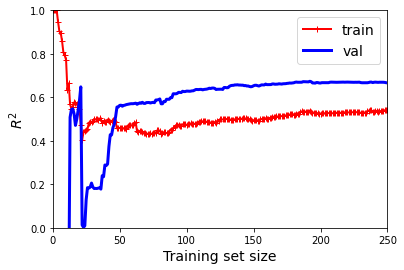

In [130]:
plot_learning_curves_R2(model, xtrain, ytrain) # This is the correct way of doing it
# however, for this assignment doing it this way:
# plot_learning_curves_R2(model, x, y) # will be also okay. 
plt.axis([0, 250, 0, 1])
plt.show()

**Written Answer:** How this learning curve compares against the rest of the learning curves? Based on the learning curves, what model and size of training set would you choose as your final model?

The curves reach a plateau around training set size of 180. Both curves saturate to higher R2 scores. Based on our experiments, the model trained for Question 4 is the best among all. However, a cross validation with size of each fold being at least 180 can give us a better evaluation over performance.

### Extras:

In [143]:
# A good guess for N can be made by taking the size of the whole training set (here, xtrain) and divide
# it by the optimal training set size that you interpret from the learning curves:
optimal_set_size = 180
N = int(xtrain.size/optimal_set_size)

scores = cross_val_score(model, xtrain, ytrain, scoring="r2", cv=N)
print("Number of folds:", N)
print("Scores of folds:\n", scores.round(3))
print("Mean:", scores.mean().round(3))
print("Standard deviation:", scores.std().round(3))

Number of folds: 12
Scores of folds:
 [0.341 0.62  0.583 0.786 0.578 0.713 0.72  0.366 0.135 0.413 0.392 0.629]
Mean: 0.523
Standard deviation: 0.185


And now, you get not only an estimate of the performance of your model, but also a measure of how precise this estimate is i.e., its standard deviation.

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  You will submit to OWL only one file, which is your completed notebook (.ipynb file extension).